In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 500)

In [33]:
# timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,cpu_percent,avg_text,avg_data,peak_rss,inputs,outputs,minor_pagefaults,major_pagefaults,swaps,alloc_mem,reclaimed_mem,rts_mem,total_gcs,minor_gcs,major_gcs,avg_mem,max_mem,n_samples,init_cpu,init_sys,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance
data_files = [
    '../data/results.csv',
    '../data/results_2.csv'
]

df = pd.concat(map(lambda file: pd.read_csv(file), data_files))
df['total_energy'] = df['pkg_energy'] + df['dram_energy']
display(df.head(5))

progs = df['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df['flag'].unique()[1:]
print(f"Flags ({len(flags)}): {flags}")

,timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,...,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance,total_energy
0,1683221035,circsim,-O2,0,245286.912,1602169.0,52734.0,0.21,0.00,0.22,...,0.118,0.118,0.101,0.101,0.093,0.093,0.008,0.008,1,1654903.0
1,1683221036,circsim,-O2,0,237353.362,1583614.0,52795.0,0.21,0.00,0.21,...,0.118,0.118,0.097,0.098,0.089,0.090,0.008,0.008,1,1636409.0
2,1683221042,circsim,-O2,0,238780.570,1529782.0,48157.0,0.19,0.02,0.21,...,0.117,0.116,0.097,0.098,0.090,0.090,0.007,0.007,1,1577939.0
3,1683221054,circsim,-O2,0,241376.445,1528561.0,48401.0,0.21,0.00,0.21,...,0.119,0.118,0.098,0.099,0.090,0.091,0.008,0.008,1,1576962.0
4,1683221066,circsim,-O2,0,244602.692,1515926.0,49377.0,0.20,0.02,0.22,...,0.120,0.120,0.100,0.100,0.092,0.092,0.008,0.008,1,1565303.0


Programs (14): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin']
Flags (24): ['-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case']


In [3]:
def calculate_increase(data, column):
    new_dataframe = []

    for prog in progs:
        base_mean = data[(data['flag'] == '-O2') & (data['program'] == prog)][column].mean()
        
        for flag in flags:
            flag_mean = data[(data['flag'] == flag) & (data['program'] == prog)][column].mean()
            increase = ((flag_mean - base_mean) / base_mean) * 100
            new_dataframe.append([prog, flag, base_mean, flag_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'flag_mean', 'increase'])

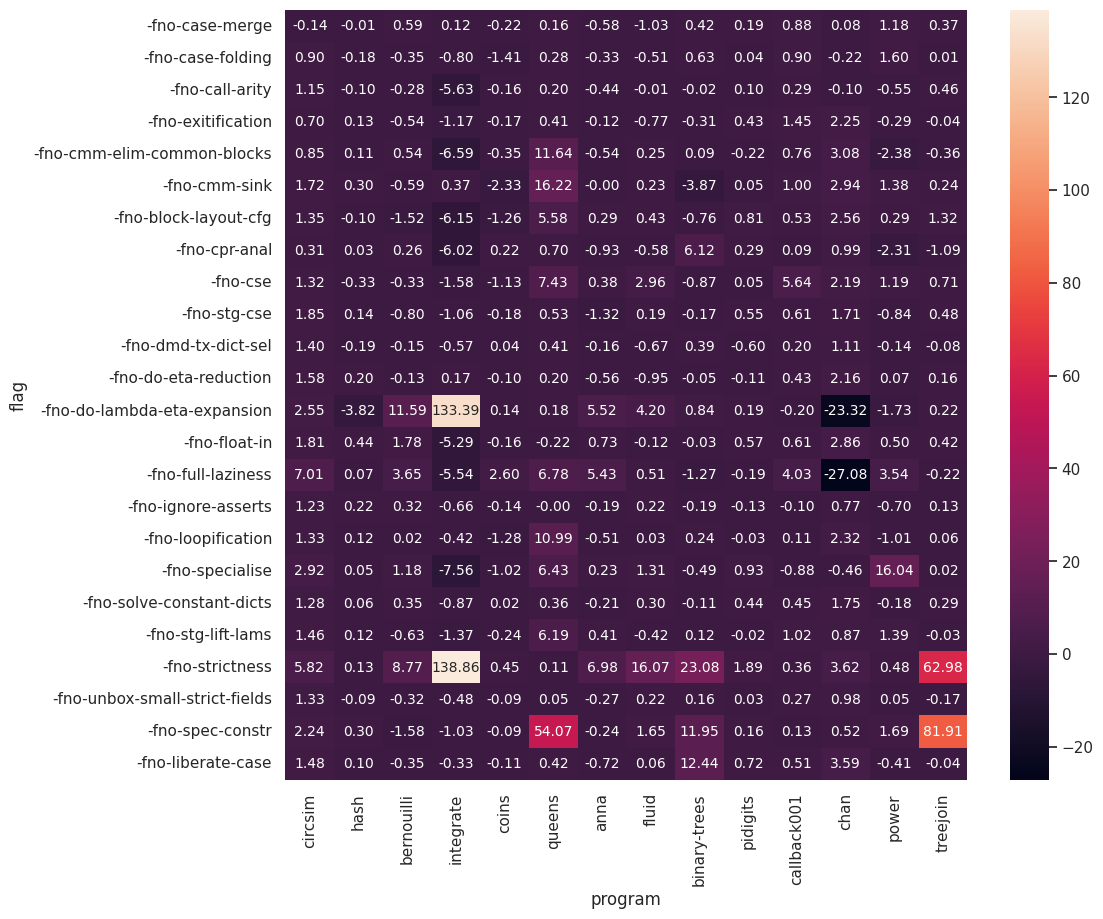

In [34]:
perc_df = calculate_increase(df, 'total_energy')

plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = perc_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = perc_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f',
    annot_kws={'fontsize': 10}
)
plt.show()

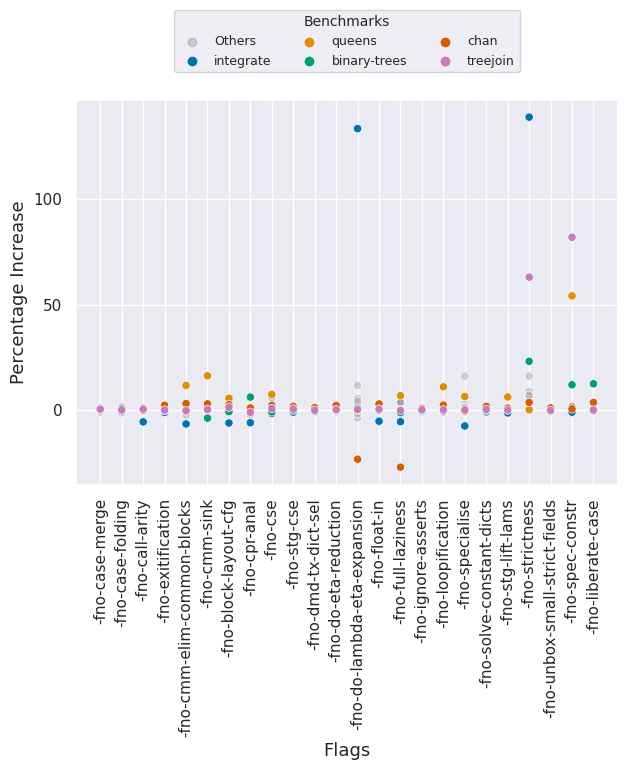

In [49]:
perc_df['Benchmark'] = ['Others'] * len(perc_df)

# special cases to be displayed
highlighted_benchmarks = ['integrate', 'queens', 'chan', 'treejoin', 'binary-trees']
perc_df['Benchmark'] = np.where(perc_df['program'].isin(highlighted_benchmarks), perc_df['program'], perc_df['Benchmark'])


# sns.set_palette('colorblind', 12)
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)

ax = sns.scatterplot(data=perc_df[perc_df['Benchmark'] == 'Others'], x='flag', y='increase', hue='Benchmark', 
    palette= {'Others': to_rgba('#949494', 0.4)})
sns.scatterplot(data=perc_df[perc_df['Benchmark'] != 'Others'], x='flag', y='increase', hue='Benchmark', ax=ax,
    palette=sns.color_palette(palette="colorblind", n_colors=len(highlighted_benchmarks)))
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.25), ncol=3, title='Benchmarks', fontsize=9, title_fontsize=10)
sns.set(font_scale=2)
ax.set_ylabel("Percentage Increase", fontsize=13)
ax.set_xlabel("Flags", fontsize=13)
# ax.set_yticks(range(-8, 11, 2))

# plt.ylim(-8, 12)
# plt.savefig(f"charts/{DATA_COL}_scatter.pdf", bbox_inches='tight')
plt.show()

sns.set(font_scale=1)

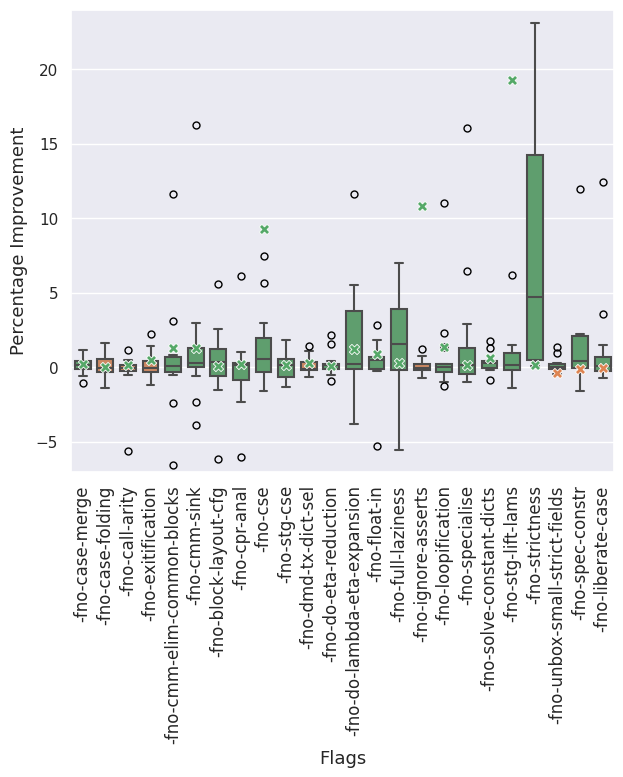

In [47]:
custom_palette = {}
for flag in flags:
    avr = perc_df[(perc_df['flag'] == flag)]['increase'].mean()
    med = perc_df[(perc_df['flag'] == flag)]['increase'].median()

    # green if med >= 0 else orange
    custom_palette[flag] = "#55a868" if med >= 0 else "#dd8452"

plt.figure(figsize=(7,6))
plt.xticks(rotation=90)

# box_widths = [1] * (len(flags) - 1)

ax = sns.boxplot(data=perc_df, x="flag", y="increase", 
    palette = custom_palette,
    flierprops=dict(marker='o', markerfacecolor='None', markersize=5, markeredgecolor='black'), width=.7)
df_means = perc_df.groupby("flag")['increase'].agg('mean').reset_index()
ax = sns.scatterplot(data=df_means[df_means['increase'] >= 0], x="flag", y="increase", marker='X', color="#55a868", s=55, zorder=3, ax=ax, legend=False)
ax = sns.scatterplot(data=df_means[df_means['increase'] < 0], x="flag", y="increase", marker='X', color="#dd8452", s=55, zorder=3, ax=ax, legend=False)

plt.xticks(fontsize=12)
plt.ylim(-7,24)
ax.set_ylabel("Percentage Improvement", fontsize = 13)
ax.yaxis.set_label_coords(-.08, .5)
ax.set_xlabel("Flags", fontsize = 13)
# plt.savefig(f"charts/{DATA_COL}_box.pdf", bbox_inches='tight')
plt.show()